In [1]:
import numpy as np
import pandas as pd
import random
from collections import deque, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# LRU cache
class LRUCache:
 
    def __init__(self, cache_size):
        self.cache = deque()
        self.cache_size = cache_size
        self.hits = 0
        self.misses = 0

    def run(self, query):
        if query in self.cache:
            self.cache.remove(query)
            self.cache.append(query)
            self.hits += 1
        else:
            self.misses += 1

            while len(self.cache) >= self.cache_size:
                self.cache.popleft()
            
            self.cache.append(query)

In [3]:
# LFU cache
class LFUCache:
 
    def __init__(self, cache_size):
        self.cache = deque()
        self.cache_size = cache_size
        self.hits = 0
        self.misses = 0
        self.frequency = {}

    def run(self, query):
        if query in self.frequency:
            self.frequency[query] += 1
        else:
            self.frequency[query] = 1
    
        if query in self.cache:
            self.hits += 1
        else:
            self.misses += 1

            while len(self.cache) >= self.cache_size:
                # evict
                min_frequency = float("inf")
                min_key = None
                for key in self.cache:
                    if key in self.frequency and self.frequency[key] <= min_frequency:
                        min_frequency = self.frequency[key]
                        min_key = key
                self.cache.remove(min_key)
            
            self.cache.append(query)

In [4]:
# LeCar implementation that uses LRU, LFU
class LeCar():

    def __init__(self, cache_size, lambda_val):
        self.cache_size = cache_size
        self.history_size = cache_size
        self.C = deque()
        self.W_LRU = 0.5
        self.W_LFU = 0.5
        self.frequency = defaultdict()
        self.history_FIFO = deque()
        self.history = {}
        self.discount_rate = 0.005 ** (1/self.history_size)
        self.lamdba = lambda_val
        self.hits = 0
        self.misses = 0
        
        self.update_weight_count = 0
        self.LRU_call_count = 0
        self.LFU_call_count = 0


    def LFU(self, cache):
        min_frequency = float("inf")
        min_key = None
        for key in cache:
            if key in self.frequency and self.frequency[key] <= min_frequency:
                min_frequency = self.frequency[key]
                min_key = key
        return min_key


    def LRU(self, cache):
        return cache[0]
    
    def update_weight(self, query):
        self.update_weight_count += 1

        if query in self.history_FIFO:
            t = len(self.history_FIFO) - self.history_FIFO.index(query)
        else:
            return self.W_LRU, self.W_LFU

        r = self.discount_rate ** t

        if self.history[query] == "LRU":
            self.W_LFU = self.W_LFU * np.exp(self.lamdba * r)

        elif self.history[query] == "LFU":
            self.W_LRU = self.W_LRU * np.exp(self.lamdba * r)


        tmp = self.W_LRU / (self.W_LRU + self.W_LFU)
        
        self.W_LRU = tmp
        self.W_LFU = 1 - tmp

        return self.W_LRU, self.W_LFU
        

    def run(self, query, w_LFU = [], w_LRU = []):
        w_LRU.append(self.W_LRU)
        w_LFU.append(self.W_LFU)
        

        if query in self.frequency:
            self.frequency[query] += 1
        else:
            self.frequency[query] = 1
            
        # ---------------------------------------#
        if query in self.C:
            # remove and append to maintain LRU
            self.C.remove(query)
            self.C.append(query)
            self.hits += 1
        
        else:
            self.misses += 1
        
            if query in self.history:

                self.W_LRU, self.W_LFU = self.update_weight(query)
                self.history_FIFO.remove(query)
                del self.history[query]
            
            # Check if we need to evict anything
            if len(self.C) == self.cache_size:
                assert(len(self.C) == self.cache_size)
                assert(query not in self.C)

                # Determine which method to use to evict
                # probabilistically
                action = "LRU"
                if random.random() < self.W_LFU:
                    action = "LFU"

                # keep history to right size
                while len(self.history) >= self.history_size:
                    elem = self.history_FIFO.popleft()
                    del self.history[elem]
                
                # Evict using LRU
                if action == "LRU":
                    self.LRU_call_count += 1
                    to_evict = self.LRU(self.C)

                    # evict from cache and add to history
                    self.C.remove(to_evict)
                    self.history_FIFO.append(to_evict)
                    self.history[to_evict] = "LRU"

                    # add new query to cache
                    self.C.append(query)

                else:
                    self.LFU_call_count += 1
                    to_evict = self.LFU(self.C)

                    # evict from cache and add to history
                    self.C.remove(to_evict)
                    self.history_FIFO.append(to_evict)
                    self.history[to_evict] = "LFU"

                    # add new query to cache
                    self.C.append(query)

                
                assert(len(self.C) == self.cache_size)
            
            # Cache not at capacity, simply add
            else:
                self.C.append(query)
                assert(len(self.C) <= self.cache_size)

In [8]:
# Load data
def load_data(filename = 'trace_10k.txt'):
    data = pd.read_csv(filename, header = None, sep=" ")
    data = data.rename(columns={0:"timestamp", 1:"object_id", 2:"object_size"})
    
    return data

data = load_data('trace_10k.txt')

In [9]:
def run_all(blocktrace):
    lecar = LeCar(100, 0.27)
    lru = LRUCache(100)
    lfu = LFUCache(100)
    w_LFU = []
    w_LRU = []

    unique = set()
    for query in blocktrace:
        lecar.run(query, w_LFU, w_LRU)
        lru.run(query)
        lfu.run(query)
        unique.add(query)

    print("Unique queries ratio: ", len(unique) / len(blocktrace))

    print("LeCar Hits: ", lecar.hits)
    print("LeCar Misses: ", lecar.misses)
    print("LeCar Hit rate: ", lecar.hits/(lecar.hits + lecar.misses))
    print("LeCar -> LRU Weight: ", lecar.W_LRU, lecar.LRU_call_count)
    print("LeCar -> LFU Weight: ", lecar.W_LFU, lecar.LFU_call_count)
    print("Update weight count: ", lecar.update_weight_count)

    print("LRU Hits: ", lru.hits)
    print("LRU Misses: ", lru.misses)
    print("LRU Hit rate: ", lru.hits/(lru.hits + lru.misses))
    print("Unique queries ratio: ", len(unique) / len(blocktrace))
    
    print("LFU Hits: ", lfu.hits)
    print("LFU Misses: ", lfu.misses)
    print("LFU Hit rate: ", lfu.hits/(lfu.hits + lfu.misses))
    
    return lecar, lru, lfu, w_LRU, w_LFU
    
    


lecar, lru, lfu, w_LRU, w_LFU = run_all(blocktrace = data["object_id"])

Unique queries ratio:  0.09149828440716737
LeCar Hits:  5891
LeCar Misses:  4601
LeCar Hit rate:  0.5614754098360656
LeCar -> LRU Weight:  0.22368450508506485 1265
LeCar -> LFU Weight:  0.7763154949149351 3236
Update weight count:  892
LRU Hits:  5032
LRU Misses:  5460
LRU Hit rate:  0.47960350743423563
Unique queries ratio:  0.09149828440716737
LFU Hits:  6163
LFU Misses:  4329
LFU Hit rate:  0.5873999237514297


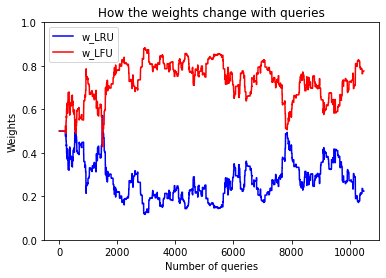

In [10]:
def plot_weights(w_LRU, w_LFU):
    plt.plot(w_LRU, "b", label="w_LRU")
    plt.plot(w_LFU, "r", label="w_LFU")
    plt.title("How the weights change with queries")
    plt.xlabel("Number of queries")
    plt.ylabel("Weights")
    plt.legend(loc="upper left")
    # fig.tight_layout()
    plt.rcParams["figure.figsize"] = (5,3)
    plt.rcParams['figure.dpi'] = 900
    plt.ylim(0,1)
    plt.legend(loc="upper left")
    plt.show()
    
plot_weights(w_LRU, w_LFU)

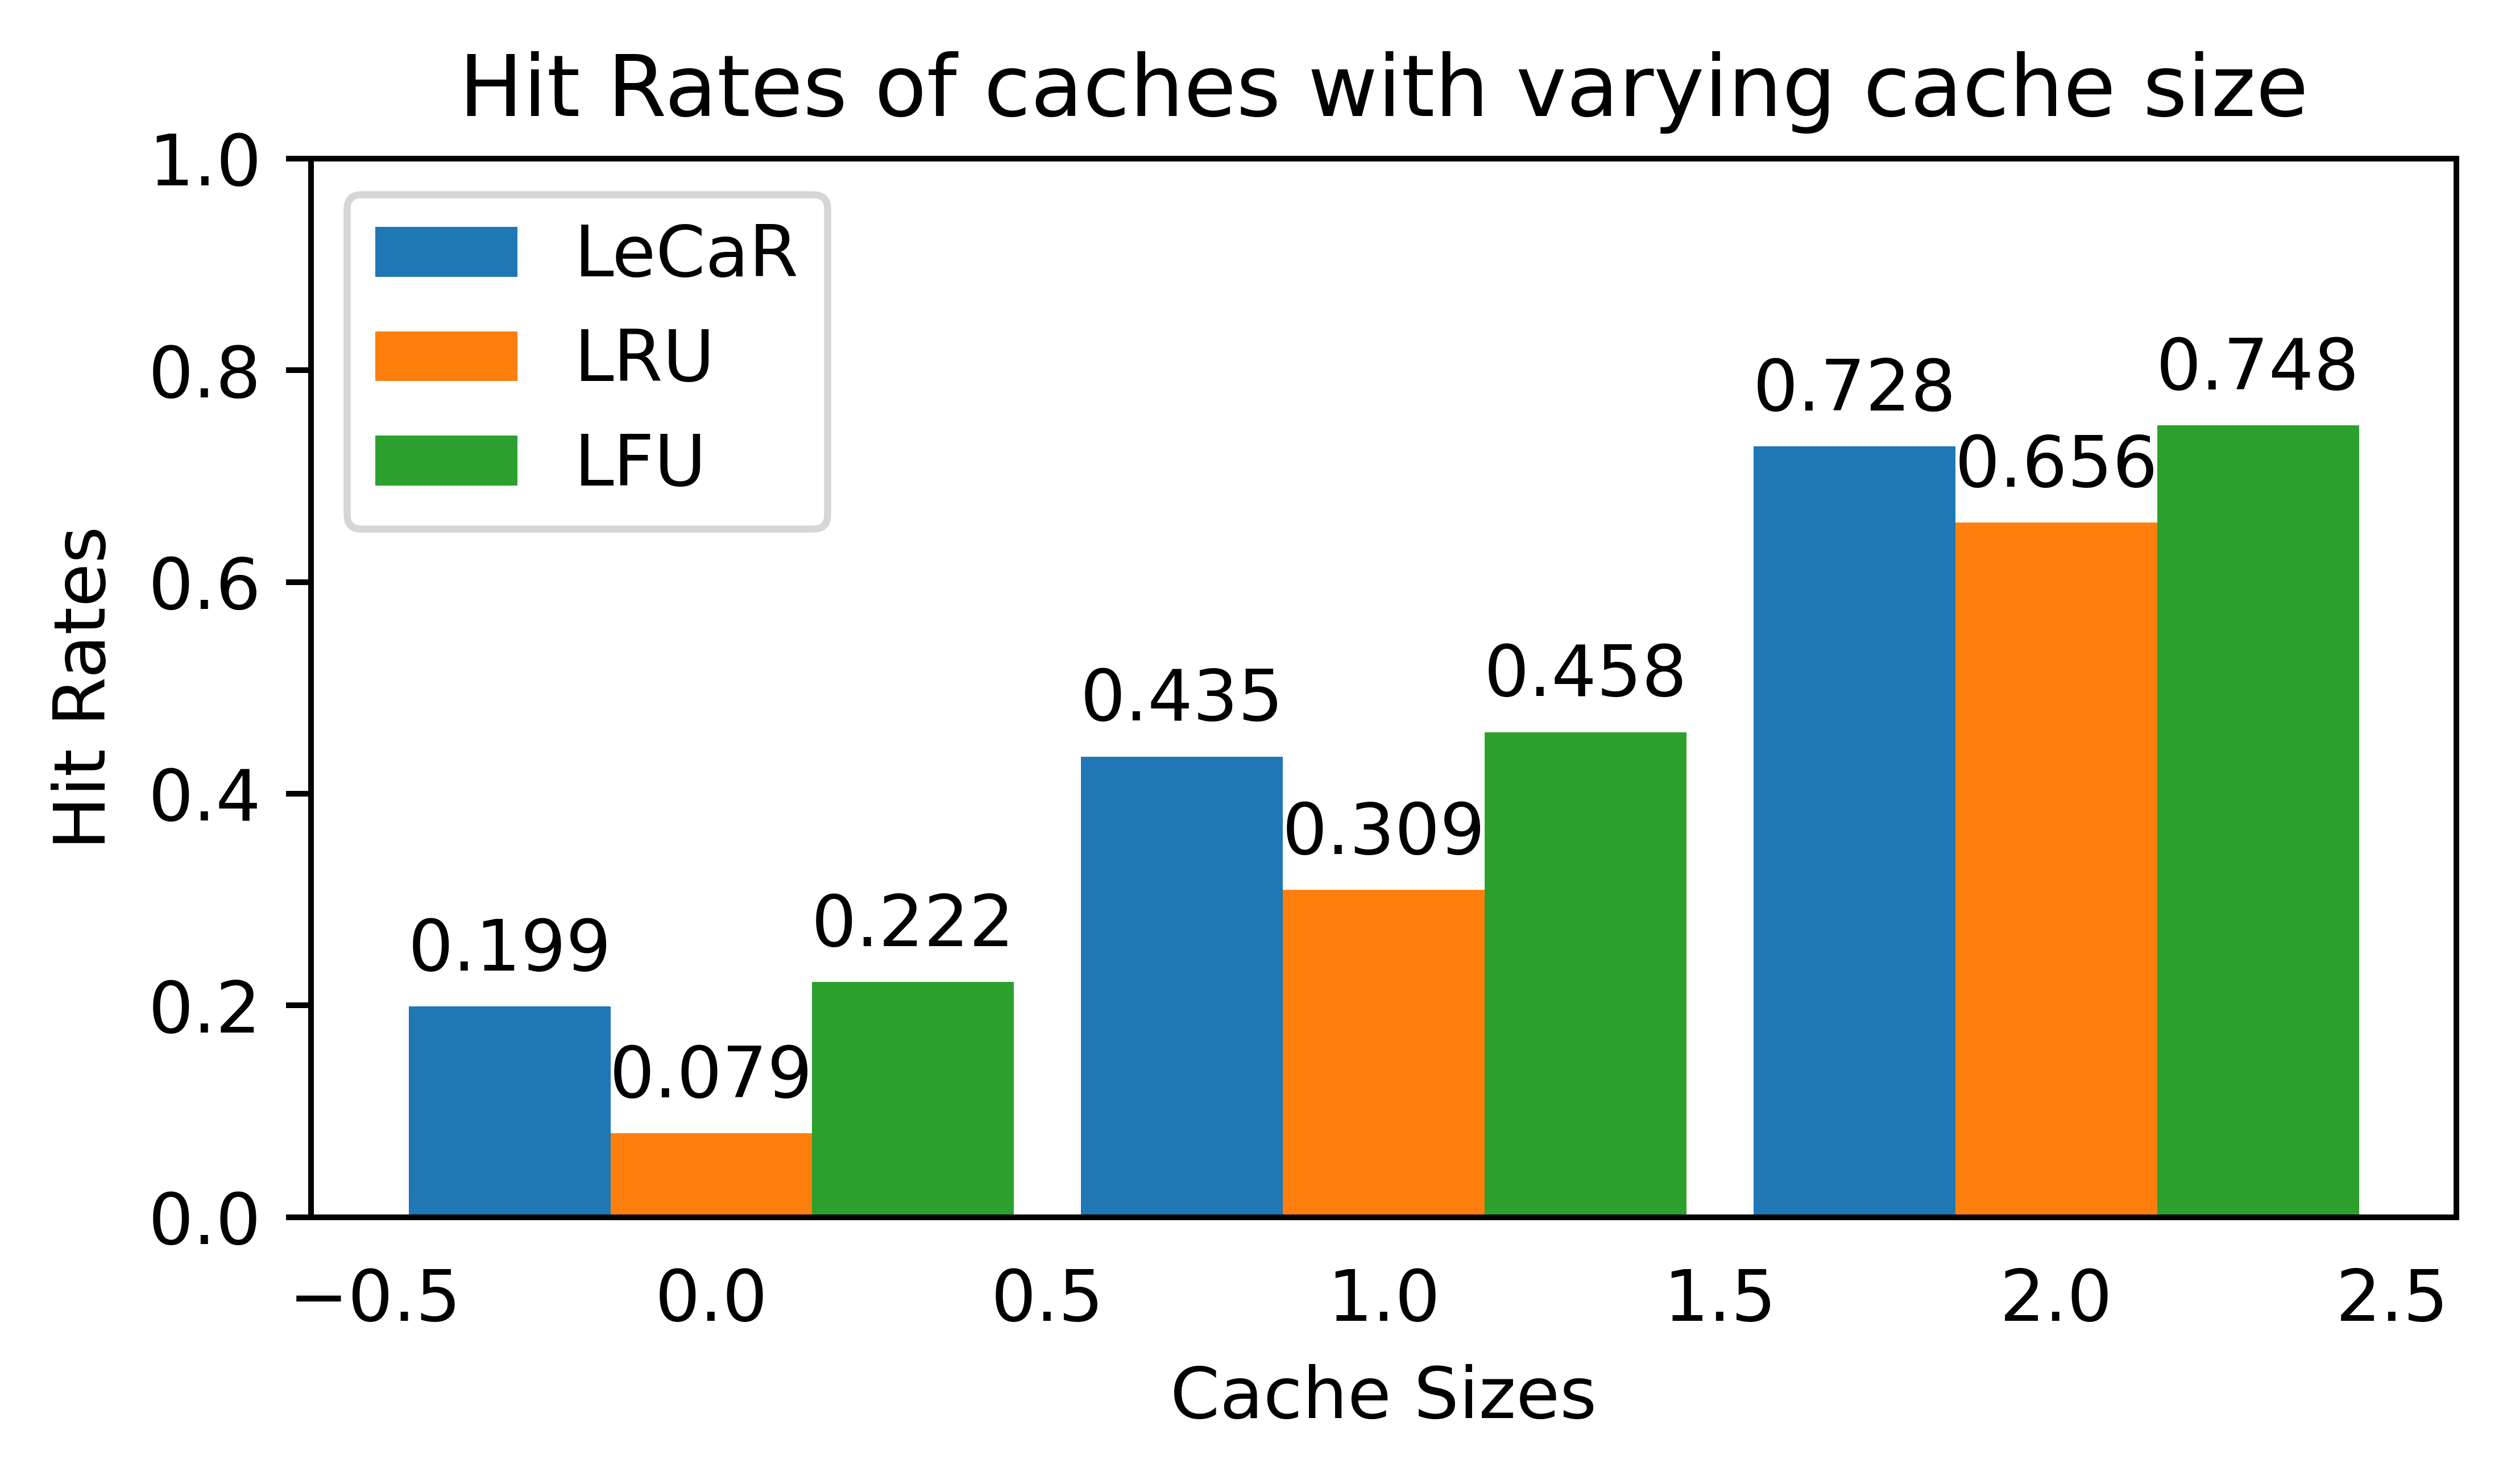

In [11]:
def plot_hit_rate():
    
    # computed from run_all function
    cache_size = ["10", "100", "1000"]
    LeCaR_HR = [0.19868845292873133, 0.43490335179489525, 0.7279993371551671]
    LRU_HR = [0.07999708576840715, 0.30906068887292093, 0.6563749530365864]
    LFU_HR = [0.2223794415246574, 0.4578064978793251, 0.7482161045580582]

    LeCaR_HR = [0.199, 0.435, 0.728]
    LRU_HR = [0.079, 0.309, 0.656]
    LFU_HR = [0.222, 0.458, 0.748]


    x = np.arange(len(cache_size))  # the label locations
    width = 0.3  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width, LeCaR_HR, width, label='LeCaR')
    rects2 = ax.bar(x, LRU_HR, width, label='LRU')
    rects3 = ax.bar(x + width, LFU_HR, width, label='LFU')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Hit Rates')
    ax.set_xlabel('Cache Sizes')
    ax.set_title('Hit Rates of caches with varying cache size', fontdict={'fontsize': 12})
    # ax.set_xticks(x, cache_size)


    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)
    ax.bar_label(rects3, padding=3)
    plt.tick_params(bottom = False)
    # ax.set_xticks(x, cache_size)

    fig.tight_layout()
    plt.rcParams["figure.figsize"] = (5,3)
    plt.rcParams['figure.dpi'] = 500
    plt.ylim(0,1)
    plt.legend(loc="upper left")


    plt.show()

plot_hit_rate()

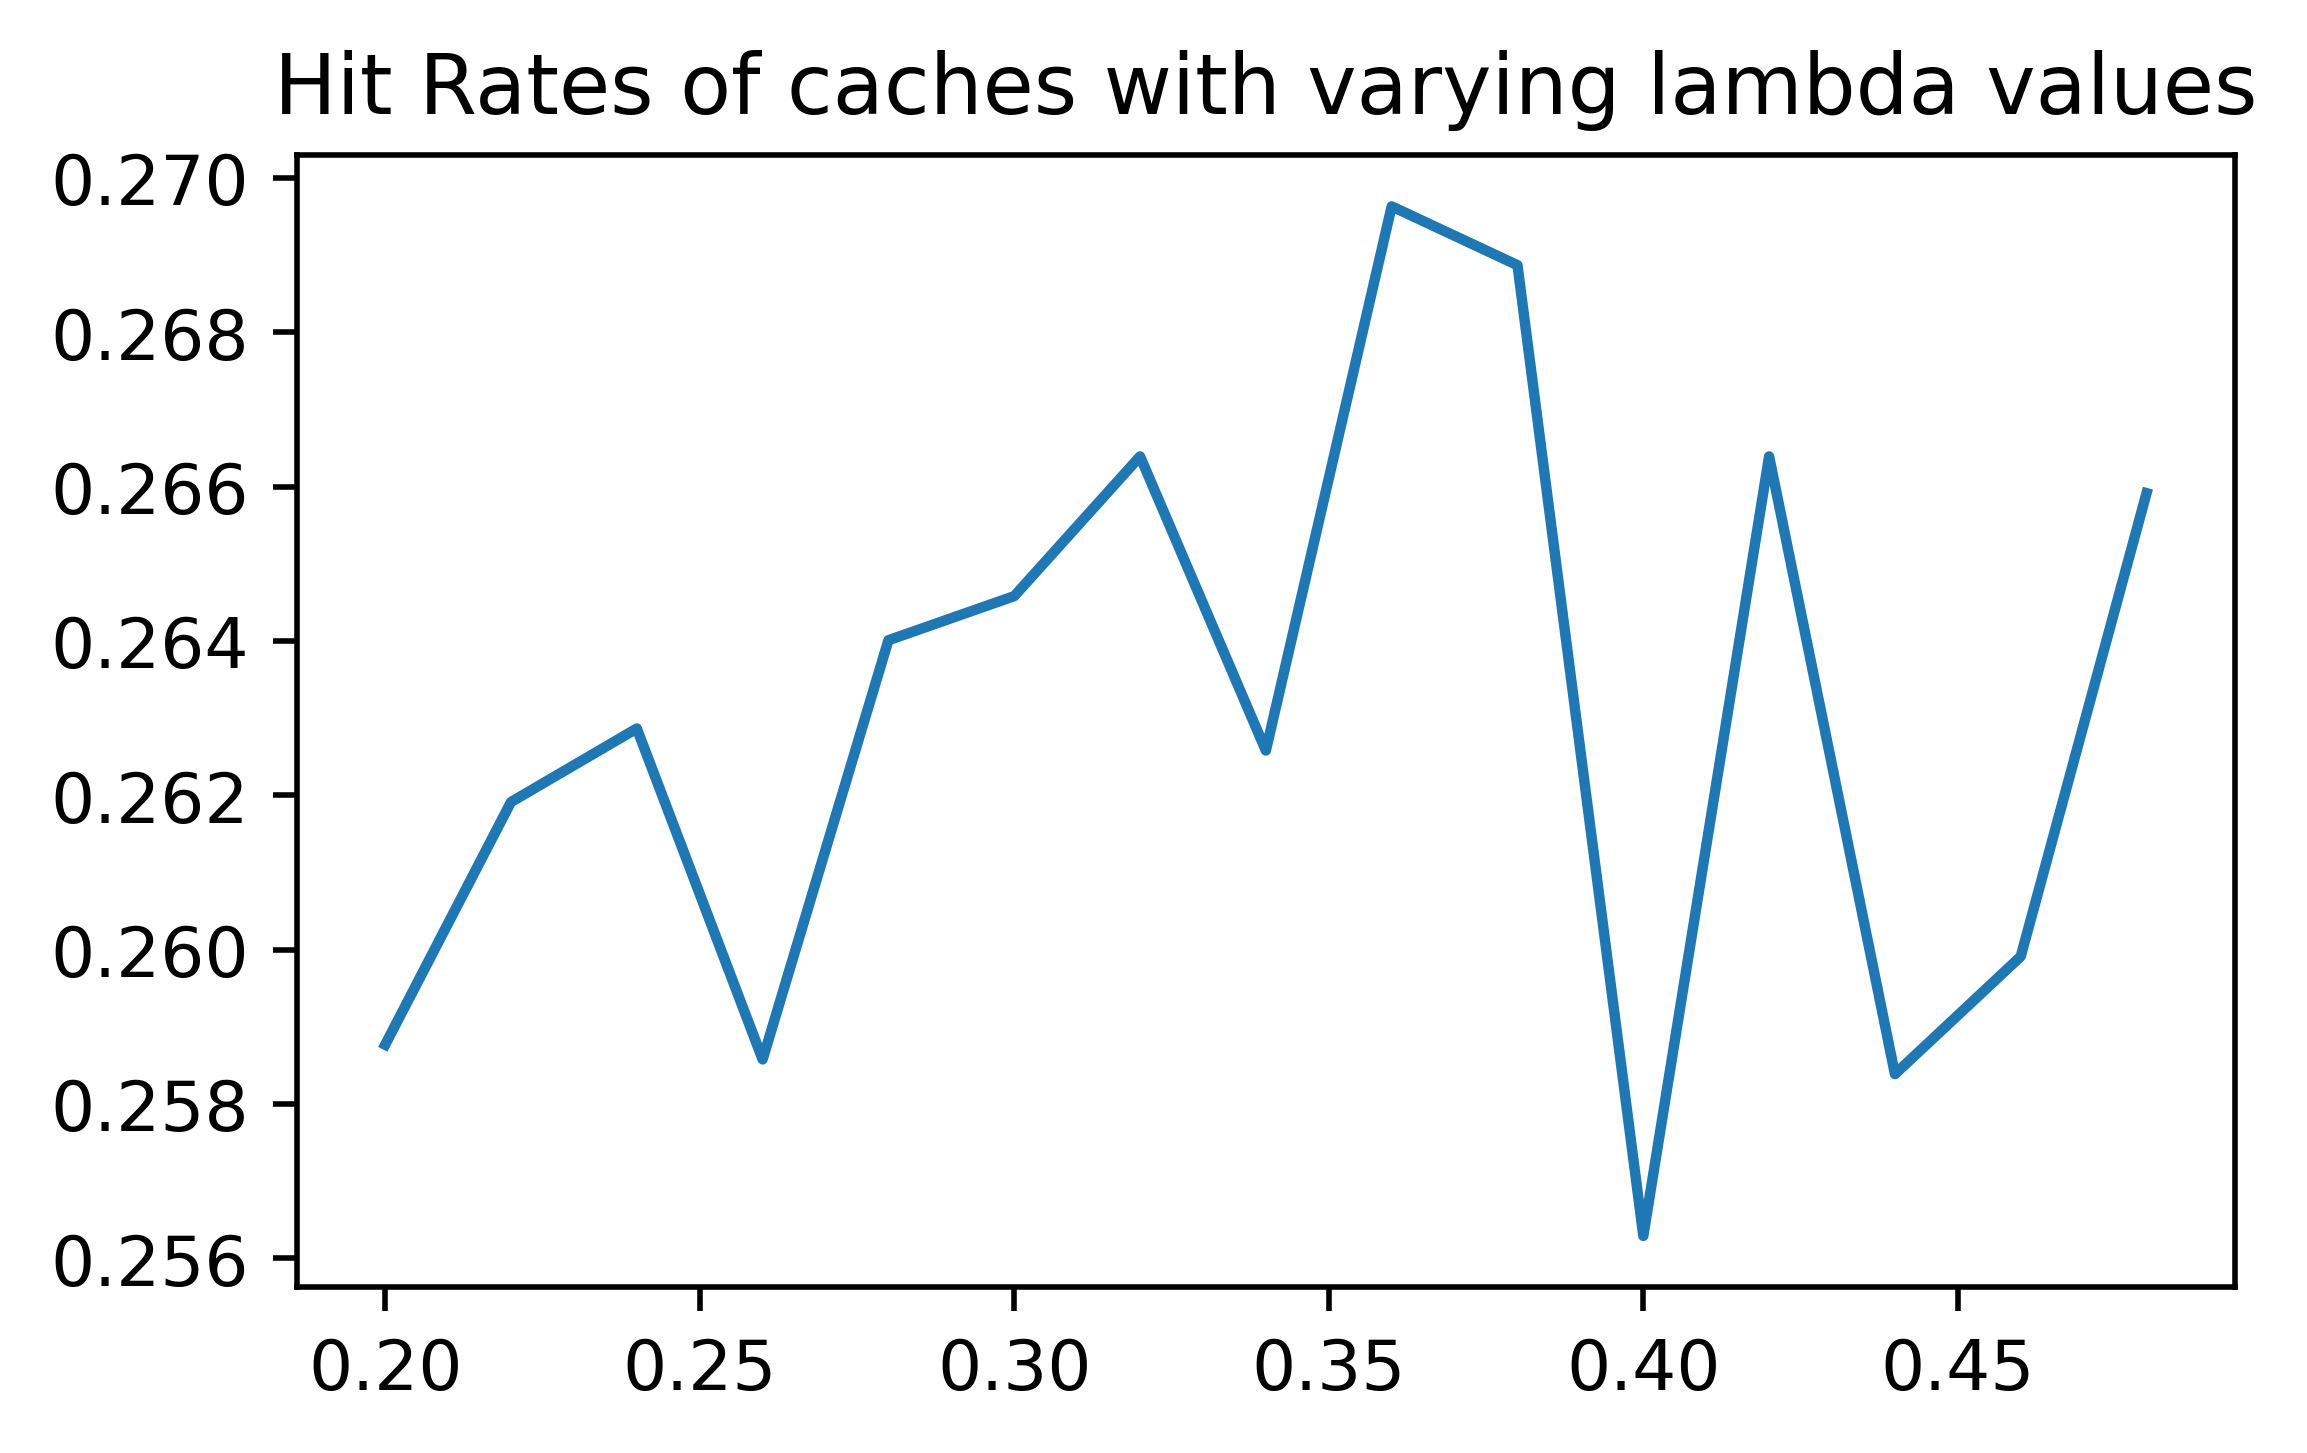

{0.2: 0.2587685855890202,
 0.22: 0.2619138391155166,
 0.24: 0.2628669462447579,
 0.26: 0.2585779641631719,
 0.28: 0.2640106747998475,
 0.3: 0.2645825390773923,
 0.32: 0.26639344262295084,
 0.34: 0.2625810141059855,
 0.36: 0.2696340068623713,
 0.38: 0.2688715211589783,
 0.4: 0.2562905070529928,
 0.42: 0.26639344262295084,
 0.44: 0.25838734273732367,
 0.46: 0.2599123141441098,
 0.48: 0.26591688905833016}

In [12]:
def plot_sensitivity(blocktrace = data["object_id"]):
    res = {}
    for i in range (20, 50, 2):
        lambda_val = i / 100
        lecar = LeCar(10, lambda_val)
        
        for query in blocktrace:
            lecar.run(query, [], [])
            
        res[lambda_val] = lecar.hits / (lecar.hits + lecar.misses)
                
    lists = sorted(res.items()) # sorted by key, return a list of tuples

    x, y = zip(*lists) # unpack a list of pairs into two tuples

    plt.title('Hit Rates of caches with varying lambda values', fontdict={'fontsize': 12})
    plt.plot(x, y)
    plt.rcParams["figure.figsize"] = (5,3)
    plt.rcParams['figure.dpi'] = 500
    plt.show()
    
    return res
plot_sensitivity()